In [7]:
from dataclasses import dataclass


@dataclass
class TimeResult:
    input_name: str
    tree_type: str
    leafs: int
    time: float


def read_times(file_path: str) -> dict[str, TimeResult]:
    results = {}
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split(";")
            
            if len(parts) != 2:
                raise ValueError(f"Invalid line: {line}")
            
            input_name = parts[0]
            time = float(parts[1])
            
            name_parts = input_name.rsplit("-", 1)
            if len(name_parts) != 2:
                raise ValueError(f"Invalid input name: {input_name} ({len(name_parts)} parts)")
            
            tree_type = name_parts[0]
            leafs_str = name_parts[1]
            leafs = int(leafs_str)
            
            if "-" in tree_type:
                _, tree_type = tree_type.split("-")
            
            results[input_name] = TimeResult(input_name, tree_type, leafs, time)
    return results

In [10]:
neighbors_times = read_times("test_times_neighbors.txt")
brackets_times = read_times("test_times_brackets.txt")
brackets_short_times = read_times("test_times_brackets_short.txt")

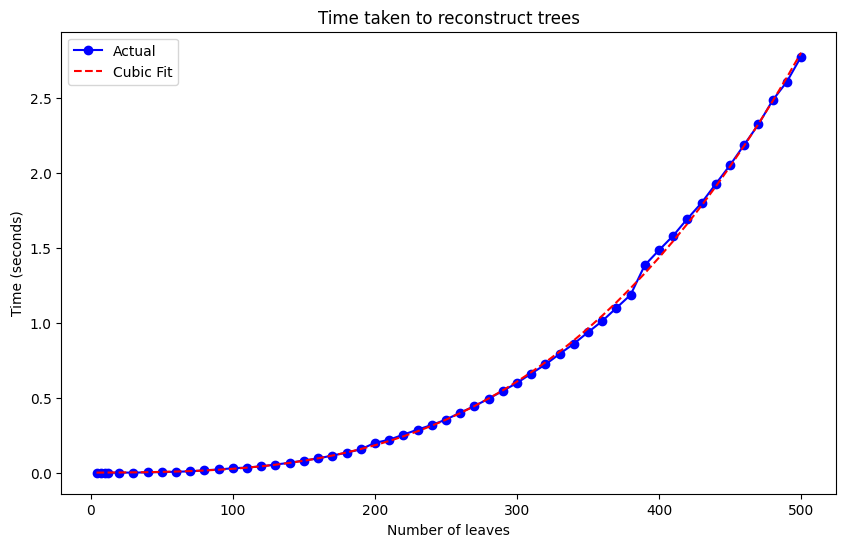

In [39]:
import matplotlib.pyplot as plt
import numpy as np


def get_x_y(times: dict[str, TimeResult]):
    leafs = sorted(set(time_result.leafs for time_result in times.values()))
    times_by_leafs = {leafs: [] for leafs in leafs}
    
    for time_result in times.values():
        times_by_leafs[time_result.leafs].append(time_result.time)
        
    avg_times = {leafs: sum(times) / len(times) for leafs, times in times_by_leafs.items()}
    x = list(avg_times.keys())
    y = list(avg_times.values())
    return x, y


def get_fit_cubic(x: list[int], y: list[float]) -> list[float]:
    a, b, c, d = np.polyfit(x, y, 3)
    return [a * i**3 + b * i**2 + c * i + d for i in x]


def plot_times(times: dict[str, TimeResult], save: bool = False):
    x, y = get_x_y(times)
    fit_y = get_fit_cubic(x, y)
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color='b', label='Actual')
    plt.plot(x, fit_y, linestyle='--', color='r', label='Cubic Fit')
    plt.title("Time taken to reconstruct trees")
    plt.xlabel("Number of leaves")
    plt.ylabel("Time (seconds)")
    plt.legend()
    if save:
        plt.savefig("times_by_leaf_count.png", transparent=True)
    plt.show()
    
plot_times(neighbors_times, save=True)

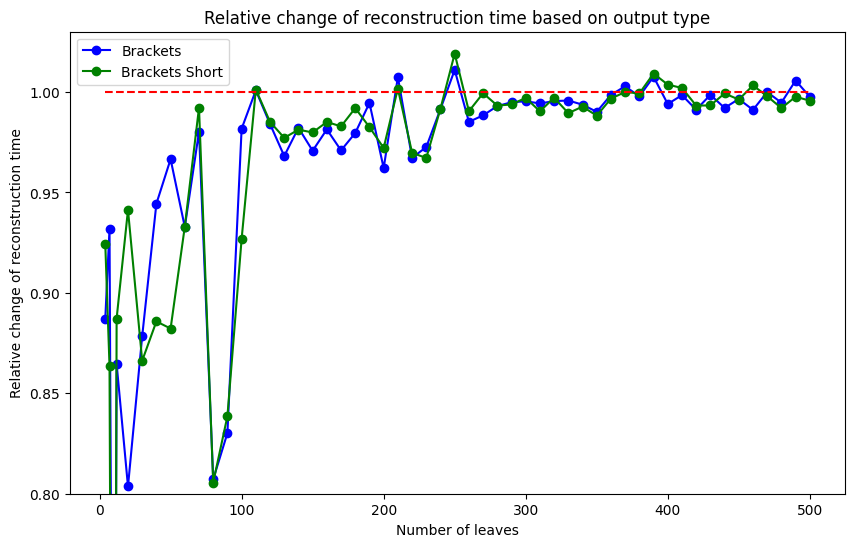

In [40]:
x, y_neighbors = get_x_y(neighbors_times)
_, y_brackets = get_x_y(brackets_times)
_, y_brackets_short = get_x_y(brackets_short_times)

y_brackets_relative = [y_brackets[i] / y_neighbors[i] for i in range(len(y_brackets))]
y_brackets_short_relative = [y_brackets_short[i] / y_neighbors[i] for i in range(len(y_brackets_short))]

plt.figure(figsize=(10, 6))
plt.plot(x, y_brackets_relative, marker='o', linestyle='-', color='b', label='Brackets')
plt.plot(x, y_brackets_short_relative, marker='o', linestyle='-', color='g', label='Brackets Short')
plt.plot(x, [1] * len(x), linestyle='--', color='r')
plt.title("Relative change of reconstruction time based on output type")
plt.xlabel("Number of leaves")
plt.ylabel("Relative change of reconstruction time")
plt.ylim(0.8, 1.03)
plt.legend()
plt.savefig("time_change_by_output_type.png", transparent=True)
plt.show()

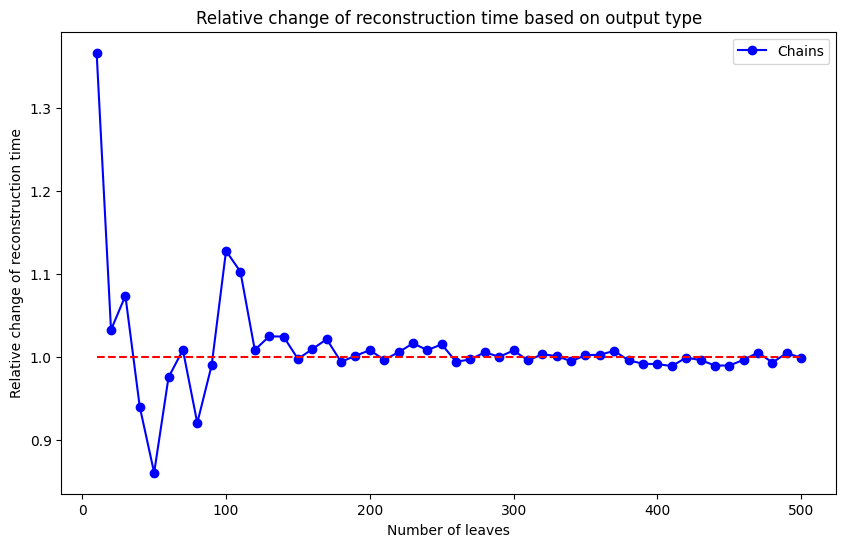

In [41]:
all_times = [*neighbors_times.values(), *brackets_times.values(), *brackets_short_times.values()]

x = list(sorted(set([time.leafs for time in all_times if time.tree_type == "default"])))
default_times = [time for time in all_times if time.tree_type == "default"]
chains_times = [time for time in all_times if time.tree_type == "chains"]

avg_default_times = [sum([time.time for time in default_times if time.leafs == leafs]) / len(default_times) for leafs in x]
avg_chains_times = [sum([time.time for time in chains_times if time.leafs == leafs]) / len(chains_times) for leafs in x]
relative_chains_times = [avg_chains_times[i] / avg_default_times[i] for i in range(len(x))]

plt.figure(figsize=(10, 6))
plt.plot(x, relative_chains_times, marker='o', linestyle='-', color='b', label='Chains')
plt.plot(x, [1] * len(x), linestyle='--', color='r')
plt.title("Relative change of reconstruction time based on output type")
plt.xlabel("Number of leaves")
plt.ylabel("Relative change of reconstruction time")
plt.legend()
plt.savefig("time_change_by_tree_type.png", transparent=True)
plt.show()